# Running the New Flux Text-to-Image Models on Google Colab (T4 GPU)

This notebook is adapted from the notebooks at https://github.com/camenduru/flux-jupyter. Go check them out!

In [1]:
# @title Set up the environment
%%capture
%cd /content
!git clone -b totoro3 https://github.com/camenduru/ComfyUI /content/TotoroUI
%cd /content/TotoroUI

!pip install -q torchsde einops diffusers accelerate xformers==0.0.27
!apt -y install -qq aria2

!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/Akul/FLUX.1-8bit/resolve/main/flux1-schnell-fp8_e4m3fn_unet.safetensors -d /content/TotoroUI/models/unet -o flux1-schnell.sft
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/Akul/FLUX.1-8bit/resolve/main/flux1-dev-fp8_e4m3fn_unet.safetensors -d /content/TotoroUI/models/unet -o flux1-dev-fp8.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/Akul/FLUX.1-8bit/resolve/main/ae.sft -d /content/TotoroUI/models/vae -o ae.sft
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/Akul/FLUX.1-8bit/resolve/main/clip_l.safetensors -d /content/TotoroUI/models/clip -o clip_l.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/Akul/FLUX.1-8bit/resolve/main/t5xxl_fp8_e4m3fn.safetensors -d /content/TotoroUI/models/clip -o t5xxl_fp8_e4m3fn.safetensors

In [2]:
# @title Set FLUX model
from nodes import NODE_CLASS_MAPPINGS
import torch

UNETLoader = NODE_CLASS_MAPPINGS["UNETLoader"]()
FLUX_Model = 'schnell (faster)' # @param ["dev (more detailed)", "schnell (faster)"]

# Store the loaded unet model
loaded_unet = None

# set model name variable for use below
if FLUX_Model == 'dev (more detailed)':
  fm = 'dev'
else:
  fm = 'schnell'

with torch.inference_mode():
    # Check if we need to change the model
    if loaded_unet is None or loaded_unet[1] != fm:
        # Delete the old model if it exists
        if loaded_unet is not None:
            del loaded_unet[0]  # Delete the old model from GPU memory
            torch.cuda.empty_cache()  # Clear CUDA cache
            loaded_unet = None

        # Load the new model
        if fm == 'schnell':
            unet = UNETLoader.load_unet("flux1-schnell.sft", "fp8_e4m3fn")[0]
            print("Loaded FLUX schnell")
        else:  # fm == 'dev'
            unet = UNETLoader.load_unet("flux1-dev-fp8.safetensors", "fp8_e4m3fn")[0]
            print("Loaded FLUX dev")

        # Store the new model
        loaded_unet = [unet, fm]

Loaded FLUX schnell


In [3]:
# @title Define model loading and inference functions
%%capture
import random
import torch
import numpy as np
from PIL import Image
import nodes
from nodes import NODE_CLASS_MAPPINGS
from totoro_extras import nodes_custom_sampler
from totoro import model_management

DualCLIPLoader = NODE_CLASS_MAPPINGS["DualCLIPLoader"]()
RandomNoise = nodes_custom_sampler.NODE_CLASS_MAPPINGS["RandomNoise"]()
BasicGuider = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicGuider"]()
KSamplerSelect = nodes_custom_sampler.NODE_CLASS_MAPPINGS["KSamplerSelect"]()
BasicScheduler = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicScheduler"]()
SamplerCustomAdvanced = nodes_custom_sampler.NODE_CLASS_MAPPINGS["SamplerCustomAdvanced"]()
VAELoader = NODE_CLASS_MAPPINGS["VAELoader"]()
VAEDecode = NODE_CLASS_MAPPINGS["VAEDecode"]()
EmptyLatentImage = NODE_CLASS_MAPPINGS["EmptyLatentImage"]()

with torch.inference_mode():
    clip = DualCLIPLoader.load_clip("t5xxl_fp8_e4m3fn.safetensors", "clip_l.safetensors", "flux")[0]
    vae = VAELoader.load_vae("ae.sft")[0]

def closestNumber(n, m):
    q = int(n / m)
    n1 = m * q
    if (n * m) > 0:
        n2 = m * (q + 1)
    else:
        n2 = m * (q - 1)
    if abs(n - n1) < abs(n - n2):
        return n1
    return n2

In [4]:
# @title Define hyperparameters (set seed to 0 for random)
with torch.inference_mode():
    positive_prompt = "A dragon flying in the sky" #@param {type:"string"}
    width = 1024 #@param {type:"integer"}
    height = 1024 #@param {type:"integer"}
    seed = 42 #@param {type:"integer", description:"Set to 0 for random seed"}
    steps = 20 #@param {type:"integer"}
    sampler_name = "ddim" #@param ["euler", "dpm_2", "heun", "lms", "ddim", "dpm_fast", "dpm_adaptive", "dpmpp_2m_sde"]
    scheduler = "ddim_uniform" #@param ["simple", "normal", "karras", "ddim_uniform"]

  0%|          | 0/20 [00:00<?, ?it/s]

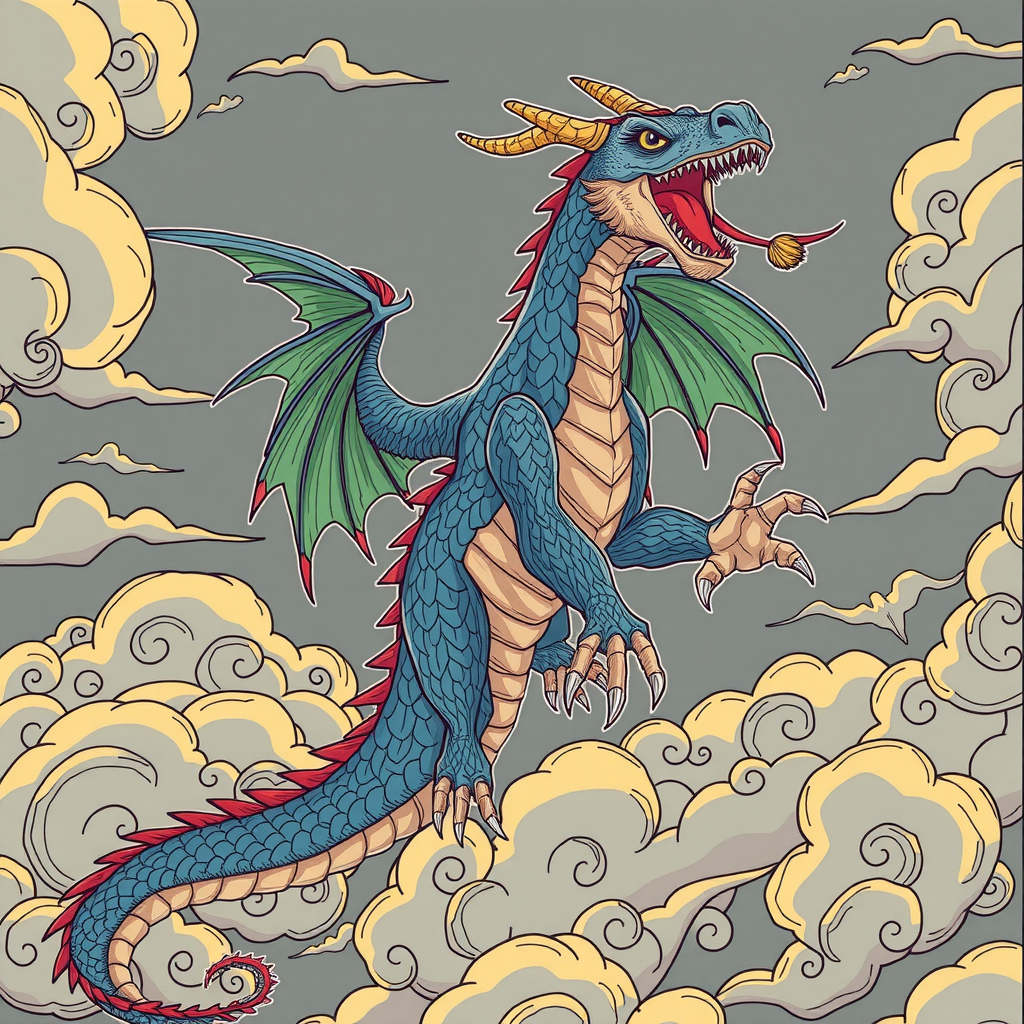

In [5]:
# @title Run the model on a T4 GPU
with torch.inference_mode():
    if seed == 0:
        seed = random.randint(0, 18446744073709551615)
    # print(seed)

    cond, pooled = clip.encode_from_tokens(clip.tokenize(positive_prompt), return_pooled=True)
    cond = [[cond, {"pooled_output": pooled}]]
    noise = RandomNoise.get_noise(seed)[0]
    guider = BasicGuider.get_guider(unet, cond)[0]
    sampler = KSamplerSelect.get_sampler(sampler_name)[0]
    sigmas = BasicScheduler.get_sigmas(unet, scheduler, steps, 1.0)[0]
    latent_image = EmptyLatentImage.generate(closestNumber(width, 16), closestNumber(height, 16))[0]
    sample, sample_denoised = SamplerCustomAdvanced.sample(noise, guider, sampler, sigmas, latent_image)
    model_management.soft_empty_cache()
    decoded = VAEDecode.decode(vae, sample)[0].detach()
    Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0]).save("/content/flux.png")

Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0])